In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [28]:
# Add new constants
MAX_UNITS = 5
VISION_RANGE = 2
EMPTY = 0
WALL = 1
CAPTURE_NEUTRAL = 2
CAPTURE_P1 = 3
CAPTURE_P2 = 4
PLAYER1 = 5
PLAYER2 = 6
# Define action constants
MOVE_NO = -1
MOVE_UP = 0
MOVE_DOWN = 1
MOVE_LEFT = 2
MOVE_RIGHT = 3
ATTACK = 4
DEFEND = 6
# Game settings
GRID_SIZE = 15
MAX_TURNS = 30
INITIAL_HEALTH = 100

class CombatArenaEnv:
    def __init__(self, grid_size=GRID_SIZE, max_turns=MAX_TURNS):
        self.grid_size = grid_size
        self.max_turns = max_turns
        self.turn = 0
        self.reset()

    def reset(self):
        # Create an empty grid and add random walls and capture points
        self.grid = np.full((self.grid_size, self.grid_size), EMPTY)
        self._place_walls()
        self._place_capture_points()

        # Initialize multiple units for each player
        self.player1 = {
            "units": [
                {
                    "position": self._get_random_empty_cell(),
                    "health": INITIAL_HEALTH,
                    "id": f"P1_U{i}"
                } for i in range(MAX_UNITS)
            ],
            "capture_points": 0
        }
        
        self.player2 = {
            "units": [
                {
                    "position": self._get_random_empty_cell(),
                    "health": INITIAL_HEALTH,
                    "id": f"P2_U{i}"
                } for i in range(MAX_UNITS)
            ],
            "capture_points": 0
        }

        self._update_grid_positions()
        self.turn = 0
        self.render_graphic()
        return self.get_observation_for_agent(True), self.get_observation_for_agent(False)

    def _place_walls(self):
    # Randomly place a few walls
        num_walls = int(self.grid_size * self.grid_size * 0.1)  # 10% cells are walls
        for _ in range(num_walls):
            x, y = random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)
            self.grid[x, y] = WALL
    
    def _place_capture_points(self):
        # Randomly place some capture points (neutral)
        num_points = int(self.grid_size * self.grid_size * 0.05)  # 5% cells are capture points
        for _ in range(num_points):
            x, y = random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)
            # Place a capture point only on an empty cell
            if self.grid[x, y] == EMPTY:
                self.grid[x, y] = CAPTURE_NEUTRAL
            
    def _get_random_empty_cell(self):
            while True:
                x, y = random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)
                if self.grid[x, y] == EMPTY:
                    return (x, y)

    def _update_grid_positions(self):
        # Clear previous player positions
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.grid[i, j] in [CAPTURE_P1, CAPTURE_P2]:
                    self.grid[i, j] = CAPTURE_NEUTRAL
                elif self.grid[i, j] in [PLAYER1, PLAYER2]:
                    self.grid[i, j] = EMPTY

        # Update positions for all units
        for unit in self.player1["units"]:
            if unit["health"] > 0:  # Only place living units
                x, y = unit["position"]
                self.grid[x, y] = PLAYER1

        for unit in self.player2["units"]:
            if unit["health"] > 0:  # Only place living units
                x, y = unit["position"]
                self.grid[x, y] = PLAYER2

    def _get_visible_area(self, position):
        """Get the visible area for a unit at given position"""
        x, y = position
        visible_grid = np.full_like(self.grid, -1)  # -1 represents fog of war
        
        for i in range(max(0, x - VISION_RANGE), min(self.grid_size, x + VISION_RANGE + 1)):
            for j in range(max(0, y - VISION_RANGE), min(self.grid_size, y + VISION_RANGE + 1)):
                visible_grid[i, j] = self.grid[i, j]
                
        return visible_grid

    def get_observation_for_agent(self, is_agent_one=True):
        """Get observation with limited visibility for each unit"""
        if is_agent_one:
            player = self.player1
            opponent = self.player2
        else:
            player = self.player2
            opponent = self.player1

        # Combine visible areas from all units
        combined_visibility = np.full_like(self.grid, -1)
        
        for unit in player["units"]:
            if unit["health"] > 0:  # Only consider living units
                visible_area = self._get_visible_area(unit["position"])
                # Update combined visibility (reveal areas visible to any unit)
                combined_visibility = np.where(visible_area != -1, visible_area, combined_visibility)

        return {
            "grid": combined_visibility,  # Limited visibility grid
            "units": [
                {
                    "position": unit["position"],
                    "health": unit["health"],
                    "id": unit["id"]
                } for unit in player["units"]
            ],
            "visible_opponents": [
                {
                    "position": unit["position"],
                    "health": unit["health"],
                    "id": unit["id"]
                } for unit in opponent["units"]
                if unit["health"] > 0 and 
                combined_visibility[unit["position"][0], unit["position"][1]] != -1
            ],
            "capture_points": player["capture_points"],
            "turn": self.turn
        }

    def _process_action(self, player,team, opponent_units, action, is_player1=True):
        reward = 0
        # Get current position
        x, y = player["position"]

        # Movement: compute new position
        if action in [MOVE_NO,MOVE_UP, MOVE_DOWN, MOVE_LEFT, MOVE_RIGHT]:
            new_x, new_y = x, y
            if action == MOVE_UP:
                new_x -= 1
            elif action == MOVE_DOWN:
                new_x += 1
            elif action == MOVE_LEFT:
                new_y -= 1
            elif action == MOVE_RIGHT:
                new_y += 1

            # Check boundaries and obstacles
            if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
                if self.grid[new_x, new_y] not in [WALL, PLAYER1, PLAYER2]:
                    player["position"] = (new_x, new_y)
                    if(self.grid[new_x,new_y]==CAPTURE_NEUTRAL):
                        self.grid[new_x, new_y] = CAPTURE_P1 if is_player1 else CAPTURE_P2
                        reward += 5
                        team["capture_points"] += 1
                else:
                    reward -= 1  # penalty for invalid move
            else:
                reward -= 1  # penalty for moving out of bounds

        elif action == ATTACK:
        # Check for adjacent enemy units and attack if found
            attack_successful = False
            for opponent in opponent_units:
                if opponent["health"] > 0:  # Only consider living opponents
                    opp_x, opp_y = opponent["position"]
                    if abs(opp_x - x) + abs(opp_y - y) == 1:  # Manhattan distance = 1
                        if random.random() < 0.7:  # 70% hit chance
                            damage = 10
                            opponent["health"] -= damage
                            reward += 10
                            attack_successful = True
                            break  # Only attack one enemy per action

            if not attack_successful:
                reward -= 2  # Penalty for invalid attack

        return reward
        
    def step(self, actions):
        """
        Expects a tuple of action dictionaries (actions_p1, actions_p2)
        Each action dictionary should map unit IDs to their actions
        """
        actions_p1, actions_p2 = actions
        rewards = [0, 0]

        # Process actions for player 1's units
        for unit_id, action in actions_p1.items():
            unit = next((u for u in self.player1["units"] if u["id"] == unit_id), None)
            if unit and unit["health"] > 0:
                rewards[0] += self._process_action(unit,self.player1, self.player2["units"], action, is_player1=True)

        # Process actions for player 2's units
        for unit_id, action in actions_p2.items():
            unit = next((u for u in self.player2["units"] if u["id"] == unit_id), None)
            if unit and unit["health"] > 0:
                rewards[1] += self._process_action(unit,self.player2, self.player1["units"], action, is_player1=False)

        self._update_grid_positions()
        self.turn += 1

        # Check if game is over
        p1_alive = any(unit["health"] > 0 for unit in self.player1["units"])
        p2_alive = any(unit["health"] > 0 for unit in self.player2["units"])
        done = self.turn >= self.max_turns or not p1_alive or not p2_alive

        return self.get_observation_for_agent(True), self.get_observation_for_agent(False), rewards, done, {}
    
    def render_graphic(self, ax=None, fig=None):

        """Render the game state with multiple units"""
        # Define colors for each grid element
        color_map = {
            EMPTY: "white",
            WALL: "black",
            CAPTURE_NEUTRAL: "yellow",
            CAPTURE_P1: "blue",
            CAPTURE_P2: "red",
            PLAYER1: "blue",
            PLAYER2: "red"
        }

        # If no axis is provided, create new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 12))  # Increased height for unit info

        # Clear previous plots
        ax.clear()

        # Create a color grid
        color_grid = np.empty((self.grid_size, self.grid_size), dtype=object)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                color_grid[i, j] = color_map.get(self.grid[i, j], "gray")

        # Plot the grid
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                rect = plt.Rectangle((j, self.grid_size - i - 1), 1, 1, 
                                facecolor=color_grid[i, j], edgecolor="black")
                ax.add_patch(rect)

                # Add unit IDs as text for player positions
                if self.grid[i, j] == PLAYER1:
                    unit = next((u for u in self.player1["units"] 
                            if u["position"] == (i, j) and u["health"] > 0), None)
                    if unit:
                        ax.text(j + 0.5, self.grid_size - i - 0.5, f'{unit["id"][-1]}', 
                            ha='center', va='center', color='white', fontweight='bold')
                
                elif self.grid[i, j] == PLAYER2:
                    unit = next((u for u in self.player2["units"] 
                            if u["position"] == (i, j) and u["health"] > 0), None)
                    if unit:
                        ax.text(j + 0.5, self.grid_size - i - 0.5, f'{unit["id"][-1]}', 
                            ha='center', va='center', color='white', fontweight='bold')

        # Set axis properties
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")

        # Create status text for units
        p1_status = "Player A Units:\n" + "\n".join(
            f"Unit {u['id'][-1]}: HP={u['health']}" 
            for u in self.player1["units"]
        )
        p2_status = "Player B Units:\n" + "\n".join(
            f"Unit {u['id'][-1]}: HP={u['health']}" 
            for u in self.player2["units"]
        )

        # Update title with game info
        title_text = (
            f"Turn: {self.turn}\n"
            f"Player A Points: {self.player1['capture_points']} | "
            f"Player B Points: {self.player2['capture_points']}\n"
            f"{p1_status}\n\n{p2_status}"
        )
        ax.set_title(title_text, pad=20, loc='left')

        # Only draw if in interactive mode
        if plt.isinteractive():
            fig.canvas.draw()
            fig.canvas.flush_events()

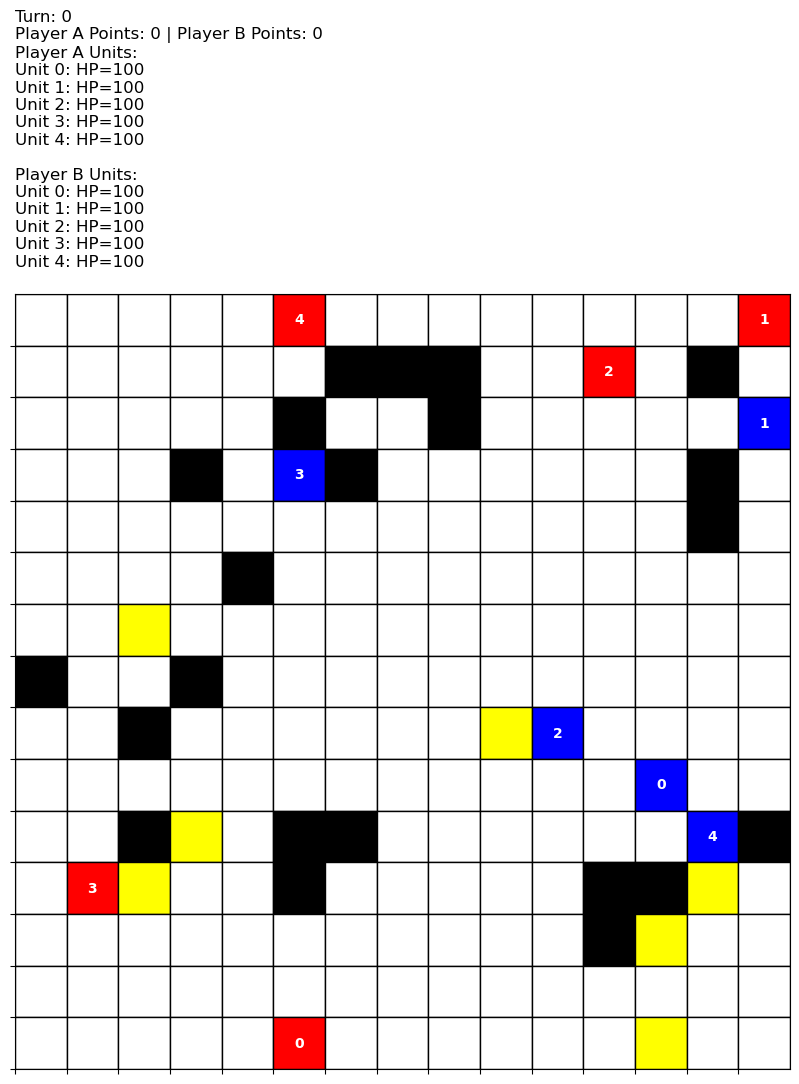

In [29]:
env=CombatArenaEnv()

In [30]:
env.get_observation_for_agent(False)

{'grid': array([[-1, -1, -1,  0,  0,  6,  0,  0, -1,  0,  0,  0,  0,  0,  6],
        [-1, -1, -1,  0,  0,  0,  1,  1, -1,  0,  0,  6,  0,  1,  0],
        [-1, -1, -1,  0,  0,  1,  0,  0, -1,  0,  0,  0,  0,  0,  5],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  6,  2,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1],
        [-1,

In [31]:
class MultiUnitAgent:
    def __init__(self, name="MultiUnitAgent"):
        self.name = name

    def select_actions(self, observation):
        """
        Returns a dictionary mapping unit IDs to actions
        """
        actions = {}
        
        for unit in observation["units"]:
            if unit["health"] > 0:  # Only act with living units
                unit_id = unit["id"]
                visible_grid = observation["grid"]
                
                # Simple example logic: move randomly if no enemies visible
                if not observation["visible_opponents"]:
                    actions[unit_id] = random.choice([MOVE_UP, MOVE_DOWN, MOVE_LEFT, MOVE_RIGHT])
                else:
                    # Attack nearest visible opponent
                    nearest_opponent = min(
                        observation["visible_opponents"],
                        key=lambda x: abs(x["position"][0] - unit["position"][0]) + 
                                    abs(x["position"][1] - unit["position"][1])
                    )
                    if abs(nearest_opponent["position"][0] - unit["position"][0]) + \
                       abs(nearest_opponent["position"][1] - unit["position"][1]) == 1:
                        actions[unit_id] = ATTACK
                    else:
                        # Move toward nearest opponent
                        dx = nearest_opponent["position"][0] - unit["position"][0]
                        dy = nearest_opponent["position"][1] - unit["position"][1]
                        if abs(dx) > abs(dy):
                            actions[unit_id] = MOVE_DOWN if dx > 0 else MOVE_UP
                        else:
                            actions[unit_id] = MOVE_RIGHT if dy > 0 else MOVE_LEFT
                            
        return actions

In [39]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle
import numpy as np

class GameVisualizer:
    def __init__(self, env, figsize=(10, 10)):
        self.env = env
        self.frames = []
        self.figsize = figsize
        
        # Define colors for grid elements
        self.color_map = {
            EMPTY: "white",
            WALL: "black",
            CAPTURE_NEUTRAL: "yellow",
            CAPTURE_P1: "blue",
            CAPTURE_P2: "red",
            PLAYER1: "blue",
            PLAYER2: "red"
        }
    
    def capture_frame(self):
        """Capture current game state including all units"""
        frame_data = {
            'grid': self.env.grid.copy(),
            'turn': self.env.turn,
            'player1_units': [{
                'position': unit['position'],
                'health': unit['health'],
                'id': unit['id']
            } for unit in self.env.player1['units']],
            'player2_units': [{
                'position': unit['position'],
                'health': unit['health'],
                'id': unit['id']
            } for unit in self.env.player2['units']],
            'p1_capture_points': self.env.player1['capture_points'],
            'p2_capture_points': self.env.player2['capture_points']
        }
        self.frames.append(frame_data)
    
    def _create_frame(self, frame_data, ax):
        """Create visualization for a single frame with multiple units"""
        ax.clear()
        
        # Draw base grid
        for i in range(self.env.grid_size):
            for j in range(self.env.grid_size):
                cell_type = frame_data['grid'][i, j]
                if cell_type not in [PLAYER1, PLAYER2]:  # Don't draw player cells, we'll add units separately
                    color = self.color_map.get(cell_type, "gray")
                    rect = Rectangle((j, self.env.grid_size - i - 1), 
                                  1, 1, 
                                  facecolor=color,
                                  edgecolor="black")
                    ax.add_patch(rect)
        
        # Draw units for both players
        for unit in frame_data['player1_units']:
            if unit['health'] > 0:  # Only draw living units
                x, y = unit['position']
                health_ratio = unit['health'] / INITIAL_HEALTH
                circle = Circle((y + 0.5, self.env.grid_size - x - 0.5), 
                              radius=0.4 * health_ratio,
                              facecolor='blue',
                              edgecolor='blue',
                              alpha=0.7)
                ax.add_patch(circle)
                # Add unit ID
                ax.text(y + 0.5, self.env.grid_size - x - 0.5, 
                       unit['id'].split('_')[1],
                       ha='center', va='center',
                       color='white', fontsize=8)

        for unit in frame_data['player2_units']:
            if unit['health'] > 0:
                x, y = unit['position']
                health_ratio = unit['health'] / INITIAL_HEALTH
                circle = Circle((y + 0.5, self.env.grid_size - x - 0.5), 
                              radius=0.4 * health_ratio,
                              facecolor='red',
                              edgecolor='red',
                              alpha=0.7)
                ax.add_patch(circle)
                ax.text(y + 0.5, self.env.grid_size - x - 0.5, 
                       unit['id'].split('_')[1],
                       ha='center', va='center',
                       color='white', fontsize=8)

        # Set grid properties
        ax.set_xlim(0, self.env.grid_size)
        ax.set_ylim(0, self.env.grid_size)
        ax.set_xticks(range(self.env.grid_size))
        ax.set_yticks(range(self.env.grid_size))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        
        # Update title with team information
        ax.set_title(f"Turn: {frame_data['turn']}\n"
                    f"Team A Points: {frame_data['p1_capture_points']} | "
                    f"Team B Points: {frame_data['p2_capture_points']}\n"
                    f"Units A: {sum(1 for u in frame_data['player1_units'] if u['health'] > 0)} | "
                    f"Units B: {sum(1 for u in frame_data['player2_units'] if u['health'] > 0)}")
    
    def save_animation(self, filename="game_replay.gif", fps=2):
        """Save captured frames as animation"""
        if not self.frames:
            raise ValueError("No frames captured!")
            
        fig, ax = plt.subplots(figsize=self.figsize)
        
        def animate(frame_idx):
            self._create_frame(self.frames[frame_idx], ax)
            return ax.patches + [ax.title]
        
        anim = animation.FuncAnimation(
            fig, animate, frames=len(self.frames),
            interval=1000/fps, blit=True
        )
        
        try:
            if filename.endswith('.mp4'):
                try:
                    writer = animation.FFMpegWriter(fps=fps)
                    anim.save(filename, writer=writer)
                except (FileNotFoundError, RuntimeError):
                    print("FFmpeg not found. Saving as GIF instead...")
                    filename = filename.replace('.mp4', '.gif')
                    anim.save(filename, writer='pillow', fps=fps)
            else:
                anim.save(filename, writer='pillow', fps=fps)
                
            print(f"Animation saved as: {filename}")
            
        except Exception as e:
            print(f"Error saving animation: {str(e)}")
            
        finally:
            plt.close(fig)

Rewards: [0, -1]

Rewards: [9, 9]

Rewards: [8, 15]

Rewards: [7, -4]

Rewards: [7, 13]

Rewards: [-5, 8]

Rewards: [6, -4]

Rewards: [19, 19]

Rewards: [19, 17]

Rewards: [29, 28]

Rewards: [27, 15]

Rewards: [39, 15]

Rewards: [15, 17]

Rewards: [-7, 5]

Rewards: [-8, 17]

Rewards: [4, 29]

Rewards: [6, 19]

Rewards: [-3, 9]

Rewards: [9, -2]

Rewards: [-4, 9]

Rewards: [8, 29]

Rewards: [8, 17]

Rewards: [8, 17]

Rewards: [8, 29]

Rewards: [8, 17]

Rewards: [9, 0]

Rewards: [-1, -1]

Rewards: [-2, -3]

Rewards: [-2, -3]

Rewards: [-2, -3]

Animation saved as: multi_unit_battle.gif


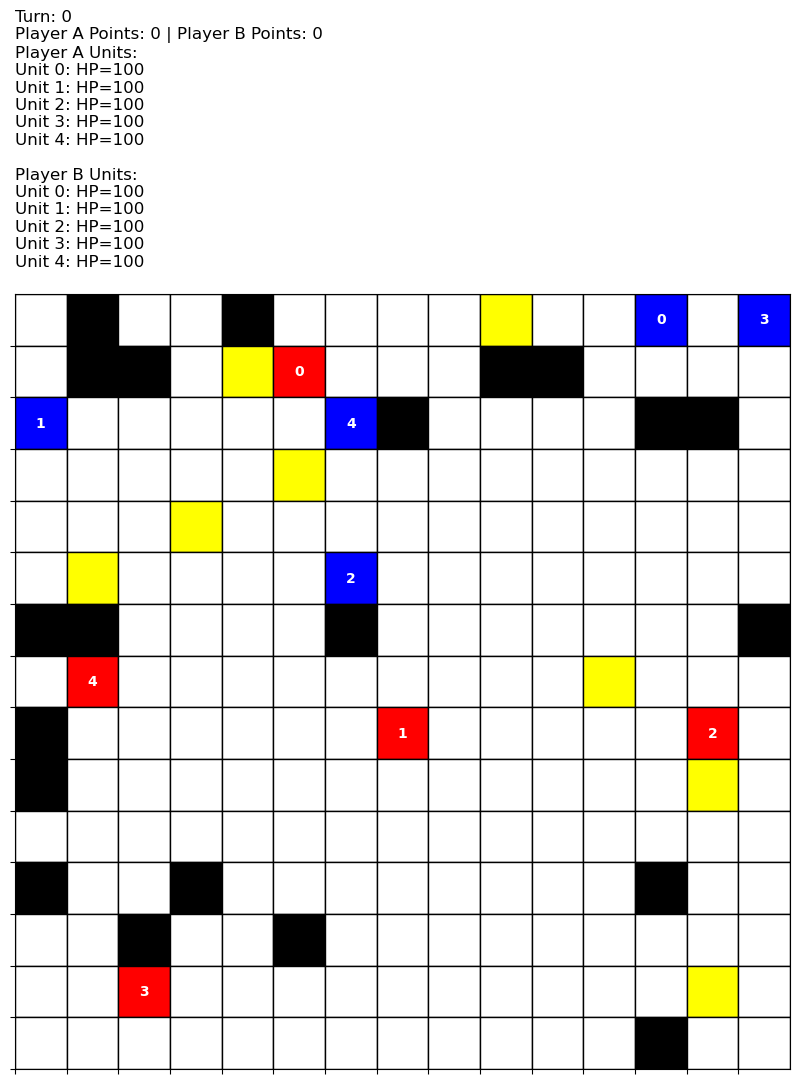

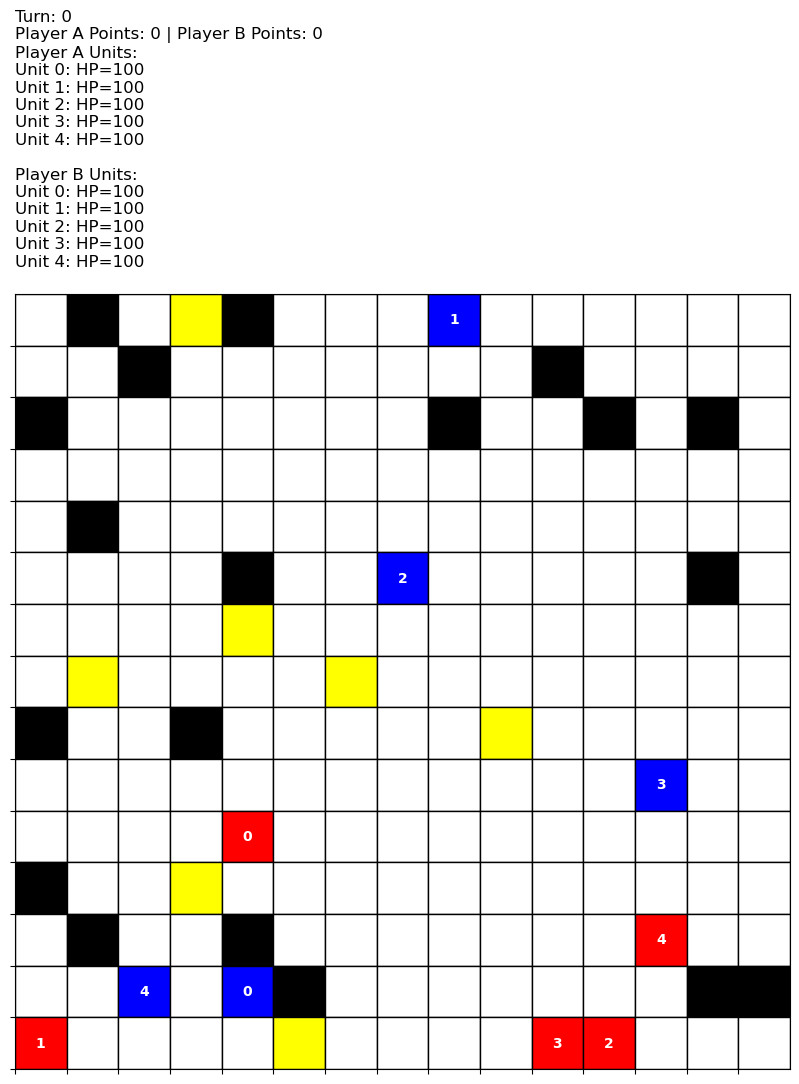

In [40]:
if __name__ == "__main__":
    env = CombatArenaEnv()
    agent_A = MultiUnitAgent(name="Squad A")
    agent_B = MultiUnitAgent(name="Squad B")
    
    vis = GameVisualizer(env)
    
    obs_A, obs_B = env.reset()
    done = False
    
    # Capture initial state
    vis.capture_frame()
    
    while not done:
        # Get actions from agents
        actions_A = agent_A.select_actions(obs_A)
        actions_B = agent_B.select_actions(obs_B)
        
        # Step environment
        obs_A, obs_B, rewards, done, info = env.step((actions_A, actions_B))
        
        # Capture frame
        vis.capture_frame()
        print(f"Rewards: {rewards}\n")
    
    # Save animation
    vis.save_animation("multi_unit_battle.gif", fps=2)